In [15]:
import os
from dotenv import load_dotenv

load_dotenv()

GOOGLE_API_KEY = os.environ.get('GOOGLE_API_KEY')

In [16]:
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model = 'gemini-2.0-flash', temperature= 0, google_api_key = GOOGLE_API_KEY)

In [17]:
from langchain_core.messages import AnyMessage, HumanMessage, AIMessage, SystemMessage
messages = [AIMessage(content = 'So you said you were researching ocean mamals?', name = 'Bot')]
messages.append(HumanMessage(content = 'Yes, I know about whales. But, what others should I learn about?', name= 'Utkarsh'))
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mamals?
================================ Human Message =================================
Name: Utkarsh

Yes, I know about whales. But, what others should I learn about?


AIMessage(content='Okay, great! Whales are a good start. To broaden your knowledge of ocean mammals, here\'s a breakdown of other key groups and some interesting examples within each:\n\n**1. Pinnipeds (Seals, Sea Lions, and Walruses):**\n\n*   **General Characteristics:** These are semi-aquatic mammals with flippers for swimming and movement on land. They are carnivores, feeding primarily on fish, squid, and crustaceans.\n*   **Seals (True Seals or Phocids):**\n    *   **Key Features:** Lack external ear flaps, have shorter flippers, and move on land by wriggling their bodies.\n    *   **Examples:** Harbor Seal, Grey Seal, Ringed Seal, Elephant Seal (largest pinniped).\n*   **Sea Lions (Eared Seals or Otariids):**\n    *   **Key Features:** Have external ear flaps, longer flippers, and can "walk" on land by rotating their hind flippers forward.\n    *   **Examples:** California Sea Lion, Steller Sea Lion, Galapagos Sea Lion.\n*   **Walruses:**\n    *   **Key Features:** Distinctive fo

In [18]:
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()


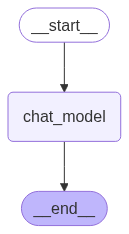

In [19]:
graph

In [26]:
messages = graph.invoke({'messages': messages})

In [27]:
for m in messages['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mamals?
================================ Human Message =================================
Name: Utkarsh

Yes, I know about whales. But, what others should I learn about?
================================== Ai Message ==================================

Okay, great! Since you know about whales, let's explore some other fascinating ocean mammals. Here's a breakdown of different types and some specific examples you might find interesting:

**1. Dolphins and Porpoises (Cetaceans - Odontocetes):**

*   **Why learn about them?** They're highly intelligent, social animals with complex communication systems. They're also often found interacting with humans.
*   **Examples:**
    *   **Bottlenose Dolphin:** The classic dolphin, often seen in aquariums and popular culture.
    *   **Spinner Dolphin:** Known for their acrobatic leaps and spins out of the water.
    *   

### We Will reduce size of messages to have lesser tokens now

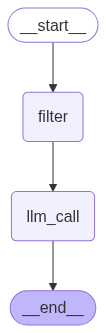

In [34]:
from langchain_core.messages import RemoveMessage
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[str], add_messages]

def filter_message(state: MessagesState):
    delete_messages = [RemoveMessage(id = m.id) for m in state['messages'][:-2]]
    return {'messages': delete_messages}

def chat_model_node(state: MessagesState):
    return {'messages': [llm.invoke(state['messages'])]}


builder = StateGraph(MessagesState)
builder.add_node('filter', filter_message)
builder.add_node('llm_call', chat_model_node)

# Logic
builder.add_edge(START, 'filter')
builder.add_edge('filter', 'llm_call')
builder.add_edge('llm_call', END)
graph = builder.compile()

graph

In [35]:
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Okay, great! Besides whales (which are cetaceans), there's a whole fascinating world of marine mammals to explore. To give you the best recommendations, tell me a little more about what interests you. For example:

*   **What aspects of marine mammals are you most interested in?** (e.g., their behavior, conservation status, physical adaptations, where they live, etc.)
*   **Are you looking for animals similar to whales, or something completely different?**
*   **Are you interested in learning about common or rare spe

## Lets try trimming messages (You can trim messages based on specified number of tokens) - LLMS HAVE CONTEXT WINDOWS WITH A PARTICULAR TOKEN LENGTH SO IT IS HIGHLY RELEVANT 

In [38]:
from langchain_core.messages import trim_messages 
from langgraph.checkpoint.memory import MemorySaver

def chat_model_node(state: MessagesState):
    messages = trim_messages(
        state['messages'],
        max_tokens = 100,
        strategy = 'last',
        allow_partial = True,
        token_counter = ChatGoogleGenerativeAI(model='gemini-2.0-flash')
    )

    return {'messages': [llm.invoke(messages)]}

builder = StateGraph(MessagesState)
builder.add_node('chat_model', chat_model_node)
# logic
builder.add_edge(START, 'chat_model')
builder.add_edge('chat_model', END)

graph_memory = builder.compile()

In [39]:
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

In [57]:
trim_messages(
        messages,
        max_tokens = 35,
        strategy = 'last',
        allow_partial = True,
        token_counter = ChatGoogleGenerativeAI(model='gemini-2.0-flash')
    )


[HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
 AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4')]